In [2]:
import pandas, numpy
import scipy, scipy.signal
import matplotlib, matplotlib.pyplot

In [3]:
scipy.__version__

'1.10.0'

In [20]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(12, 8), 'svg.fonttype' : 'none'})

In [5]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [6]:
path = output_file_directory + "ATG7/TCGA_GTEX/all_tissues/"
path2 = 'dataframes_for_input/'

In [7]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
path = output_file_directory + "dataframes_for_input/"
protcoding_normal = pandas.read_csv(path+"ensembl_normal_protcoding_expr.tsv", sep = "\t")
protcoding_primary = pandas.read_csv(path+"ensembl_primary_protcoding_expr.tsv", sep = "\t")

for df in protcoding_normal, protcoding_primary:
    df.set_index('sample', inplace = True)

protcoding_normal = protcoding_normal.T
protcoding_primary = protcoding_primary.T
    
print(protcoding_normal.shape)
print(protcoding_primary.shape)

protcoding_primary.head()

(19382, 7429)
(19382, 9185)
Wall time: 3min 41s


sample,TCGA-02-0047-01,TCGA-02-0055-01,TCGA-02-2483-01,TCGA-02-2485-01,TCGA-04-1331-01,TCGA-04-1332-01,TCGA-04-1337-01,TCGA-04-1338-01,TCGA-04-1341-01,TCGA-04-1343-01,...,TCGA-ZP-A9D4-01,TCGA-ZQ-A9CR-01,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CG-01,TCGA-ZT-A8OM-01,TCGA-ZU-A8S4-01,TCGA-ZX-AA5X-01
ENSG00000198888,12.920386,10.398268,11.694535,10.430545,14.069484,11.247293,13.430831,14.404566,12.395667,12.351376,...,14.122881,14.149479,12.713715,12.232300,12.464055,13.025373,12.100828,9.103023,11.357549,13.154958
ENSG00000198763,13.122162,10.778221,12.025246,10.518083,14.629057,10.893758,12.828698,14.866248,12.013249,12.478952,...,14.340869,14.552860,13.723207,11.795306,12.531943,13.249348,12.711915,8.416923,11.687737,13.120462
ENSG00000198804,14.013687,12.394768,13.115462,11.979057,14.281572,12.486651,14.489063,15.085541,12.395568,13.781902,...,14.396867,15.449332,13.898394,14.020387,14.084583,14.582059,13.973390,9.862349,12.407365,14.522361
ENSG00000198712,13.525222,12.389569,13.408733,11.614360,14.285772,11.943466,14.338870,14.108482,12.995077,13.855597,...,14.744952,14.156079,13.273246,13.605116,13.007075,13.967890,14.316671,11.007300,12.904388,14.541460
ENSG00000228253,13.843998,11.728425,13.628814,12.047740,13.898994,11.458412,13.495425,15.164139,11.962761,12.684919,...,15.057742,14.800151,13.996188,13.326440,13.355538,14.657256,13.876396,6.897242,12.643925,14.217176


In [8]:
#Download the filtered sample list
path = "samples_IDs/filtered_samples_list"

samples_list_normal= numpy.loadtxt(input_file_directory+path+'_normal.tsv', delimiter="\t", dtype=str)
samples_list_primary= numpy.loadtxt(input_file_directory+path+'_primary.tsv', delimiter="\t", dtype=str)

print(len(samples_list_normal), len(samples_list_primary))

5903 8022


In [9]:
# Only select the filtered samples
protcoding_normal = protcoding_normal[samples_list_normal]
protcoding_primary = protcoding_primary[samples_list_primary]

print('normal_tissue' , protcoding_normal.shape)
print('primary_tumors' , protcoding_primary.shape)

normal_tissue (19382, 5903)
primary_tumors (19382, 8022)


# Quantification

In [10]:
%%time
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/

# NORMAL
# step 1/3: sorting sample values
df_sorted_norm = pandas.DataFrame(numpy.sort(protcoding_normal.values, axis=0), 
                             index=protcoding_normal.index, columns=protcoding_normal.columns)
# step 2/3: averaging rank values across samples
df_mean_norm = df_sorted_norm.mean(axis=1)
df_mean_norm.index = numpy.arange(1, len(df_mean_norm) + 1)
# step 3/3: re-ordering samples
quantif_df_norm = protcoding_primary.rank(method="min").stack().astype(int).map(df_mean_norm).unstack()

# same for PRIMARY
df_sorted_prim = pandas.DataFrame(numpy.sort(protcoding_primary.values, axis=0), 
                             index=protcoding_primary.index, columns=protcoding_primary.columns)
df_mean_prim = df_sorted_prim.mean(axis=1)
df_mean_prim.index = numpy.arange(1, len(df_mean_prim) + 1)
quantif_df_prim= protcoding_primary.rank(method="min").stack().astype(int).map(df_mean_prim).unstack()

Wall time: 2min 21s


15.179136886236856
0
15.179136886236856
0
Wall time: 38.4 s


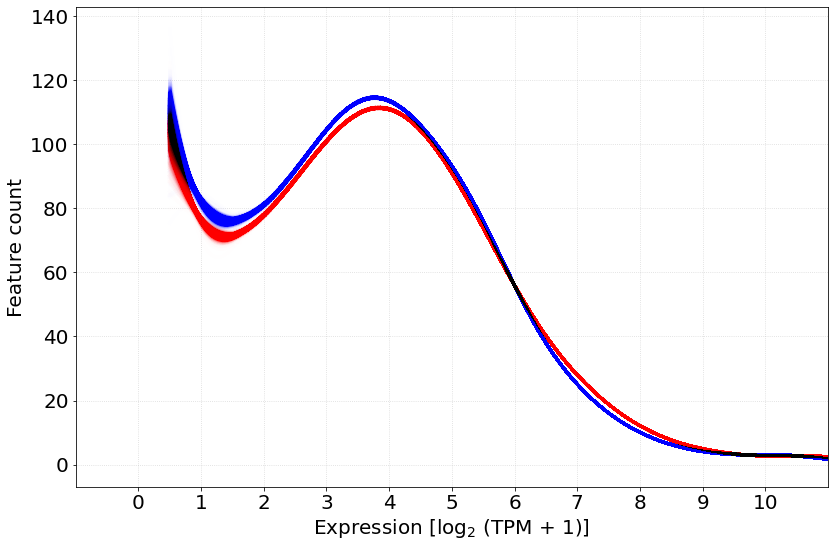

In [22]:
%%time
found_max = 15
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/2)

most_likely_expressions = []

selected_samples = []

dfs = quantif_df_norm, quantif_df_prim
colors = 'blue', 'red'

for i in range(len(dfs)):
    df = dfs[i]
    color_ = colors[i]
    
    for sample in df.columns:
        expression_values = df.loc[:, sample]

        # histogram
        hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
        half_bin = (bin_edges[1] - bin_edges[0])/2
        x = bin_edges + half_bin
        x = x[:-1]

        # curve fitting
        plotting_x = x[margin:-margin]
        plotting_hist = hist[margin:-margin]
        yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)

        # determine most likely expression
        most_likely_expression = x[numpy.argmax(yhat)]
        most_likely_expressions.append(most_likely_expression)

        # sample selection
        if 1 <= most_likely_expression <= 2:
            selected_samples.append(sample)

        # plotting
        matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color=color_)

        # check
        if numpy.max(expression_values) > absolute_max:
            absolute_max = numpy.max(expression_values)

    # check print
    print(absolute_max)
    print(len(selected_samples))

    matplotlib.pyplot.xlim(-1, 11)                  
    matplotlib.pyplot.xticks(range(0, 10+1))
    matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
    matplotlib.pyplot.ylabel('Feature count')
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
#     matplotlib.pyplot.show()
#     matplotlib.pyplot.close()

## Convert expression to z-score

In [12]:
%%time
# zscore not working because min in zero
quantif_df_norm = quantif_df_norm+0.0000000000000000000000001
quantif_df_prim = quantif_df_prim+0.0000000000000000000000001
print(type(quantif_df_norm))
zscore_df_norm = scipy.stats.zscore(quantif_df_norm, axis=1)
zscore_df_prim = scipy.stats.zscore(quantif_df_prim, axis=1)
zscore_df_prim.std(axis=1)

<class 'pandas.core.frame.DataFrame'>
Wall time: 12.7 s


ENSG00000198888    1.000062
ENSG00000198763    1.000062
ENSG00000198804    1.000062
ENSG00000198712    1.000062
ENSG00000228253    1.000062
                     ...   
ENSG00000181817    1.000062
ENSG00000116885    1.000062
ENSG00000116898    1.000062
ENSG00000119535    1.000062
ENSG00000142694    1.000062
Length: 19382, dtype: float64

In [16]:
zscore_df_norm

sample,TCGA-02-0047-01,TCGA-02-0055-01,TCGA-02-2483-01,TCGA-02-2485-01,TCGA-04-1331-01,TCGA-04-1337-01,TCGA-04-1343-01,TCGA-04-1348-01,TCGA-04-1356-01,TCGA-04-1357-01,...,TCGA-ZP-A9CV-01,TCGA-ZP-A9D1-01,TCGA-ZP-A9D2-01,TCGA-ZP-A9D4-01,TCGA-ZQ-A9CR-01,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CG-01,TCGA-ZU-A8S4-01,TCGA-ZX-AA5X-01
ENSG00000198888,0.858567,-1.641296,-0.817738,-1.460724,1.418431,1.716895,-0.280685,0.228008,2.362884,0.858567,...,-0.191072,-0.357442,-0.092949,0.689164,1.418431,1.127700,0.151200,-0.392565,-0.755071,1.237905
ENSG00000198763,0.922163,-1.863125,-0.845039,-1.746807,2.075188,1.017576,-0.386032,1.202671,1.773345,1.202671,...,-0.589084,-0.542439,-0.589084,1.107189,1.310914,1.413095,0.533368,-0.441870,-0.874372,0.533368
ENSG00000198804,0.394815,-0.607672,0.003669,-0.943794,0.003669,0.934959,0.394815,0.934959,0.253207,0.934959,...,0.003669,0.003669,0.394815,-0.128229,0.934959,0.253207,0.394815,-0.128229,-1.731304,0.394815
ENSG00000198712,0.063844,-1.114776,0.501535,-2.561114,0.501535,0.861784,0.861784,0.501535,-0.194964,0.664028,...,-0.069663,-0.328374,-0.194964,0.501535,0.063844,-0.069663,-0.069663,0.664028,-0.194964,0.861784
ENSG00000228253,0.279934,-2.542496,0.907314,-0.278638,-0.278638,0.279934,-1.441941,0.568843,-0.071082,0.568843,...,-1.546308,-0.071082,0.050297,0.907314,0.164877,0.568843,0.568843,-0.385629,-1.016300,0.279934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000181817,0.974874,2.166402,1.358828,0.902713,0.112946,0.239015,0.898060,0.232200,0.008334,1.124272,...,-0.029807,-0.050105,0.844380,-0.458561,0.199210,0.746222,-0.341286,0.106311,0.890047,0.104423
ENSG00000116885,0.365144,0.792583,-0.058924,0.221556,0.980271,1.467022,1.273681,0.504237,1.342787,0.902550,...,-1.139760,-1.550843,-0.260623,-0.555708,-1.115265,1.507606,-1.945768,0.043398,0.923629,-0.966232
ENSG00000116898,-1.509812,0.668225,0.019411,-0.515319,1.252108,0.356152,1.096699,1.813713,1.140127,0.353054,...,0.684281,0.818482,0.727543,0.862533,0.434967,1.619901,0.270905,0.795852,0.664657,0.606588
ENSG00000119535,0.917727,1.485289,0.632753,-0.383568,-0.685203,-0.002838,0.510394,0.313264,2.992498,1.096410,...,-0.233463,-0.760315,-0.536601,-0.566819,0.625805,0.991493,-0.983159,-0.381682,0.808571,0.747600


In [14]:
print(zscore_df_norm.max().max())
print(zscore_df_norm.min().min())

print(zscore_df_prim.max().max())
print(zscore_df_prim.min().min())

89.56003573022959
-12.025526966714123
89.56003573022957
-12.339115882962048


In [23]:
#save to csv
path = 'dataframes_for_input/'
zscore_df_norm.to_csv(output_file_directory+path+'zscore_df_norm.tsv',sep = "\t")
zscore_df_prim.to_csv(output_file_directory+path+'zscore_df_prim.tsv',sep = "\t")